In [1]:
import time

from numpy import random

from pathlib import Path

import cv2

import torch
from torch import nn

from hubconf import yolov5s

from detect import read_image, load_names, overlay_boxes
from utils.image_utils import cv2_imshow

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda')

## Model Definition and Initialization

In [3]:
model = yolov5s(pretrained=True, min_size=320, max_size=416, score_thresh=0.5)

In [4]:
model.eval()
model = model.to(device)

## Add Parameters for Model and Detection

In [5]:
class DotDict(dict):
    def __getattr__(self, item):
        return self[item]

In [6]:
opt = DotDict({
    'input_source': './test/assets/bus.jpg',
    'output_dir': './test/assets/output',
    'save_txt': False,
    'save_img': True,
})

In [7]:
# half = device.type != 'cpu'  # half precision only supported on CUDA
is_half = False

# Load model
if is_half:
    model.half()  # to FP16

# Get names and colors
opt.names = load_names('./notebooks/assets/coco.names')
opt.colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(opt.names))]

# Run inference on dummy input
img = torch.zeros((1, 3, 416, 416), device=device)  # init img
_ = model(img)

In [8]:
path = opt.input_source

img_test = read_image(path, is_half)
img_test = img_test.to(device)

In [9]:
with torch.no_grad():
    t1 = time.time()
    model_out = model([img_test])
    time_consumed = time.time() - t1

## Varify the Inference Output in `pytorch` backend

In [10]:
model_out[0]['boxes']

tensor([[ 48.4041, 401.9219, 237.0266, 897.8111],
        [215.3344, 408.0325, 344.7906, 857.3686],
        [ 13.2764, 225.2432, 802.3018, 735.7723],
        [674.4550, 397.7541, 812.1368, 868.5444]], device='cuda:0')

*Target outputs of boxes:*

```
tensor([[ 48.4041, 401.9219, 237.0266, 897.8111],
        [215.3344, 408.0325, 344.7906, 857.3686],
        [ 13.2764, 225.2432, 802.3018, 735.7723],
        [674.4550, 397.7541, 812.1368, 868.5444]])
```

In [11]:
model_out[0]['scores'].cpu().detach()

tensor([0.8940, 0.8635, 0.8609, 0.7063])

*Target outputs of scores:*

```
tensor([0.8940, 0.8635, 0.8609, 0.7063])
```

In [12]:
model_out[0]['labels'].cpu().detach()

tensor([0, 0, 5, 0])

*Target outputs of labels:*

```
tensor([0, 0, 5, 0])
```

## Detection output visualisation

In [13]:
detections = overlay_boxes(model_out, path, time_consumed, opt)

im = cv2.imread(str(Path(opt.output_dir).joinpath(Path(path).name)))
print(f'Output image address: {Path(opt.output_dir).joinpath(Path(path).name)}')

3 persons, 1 buss, Done. (0.015s)
Output image address: data-bin/demo/output/bus.jpg


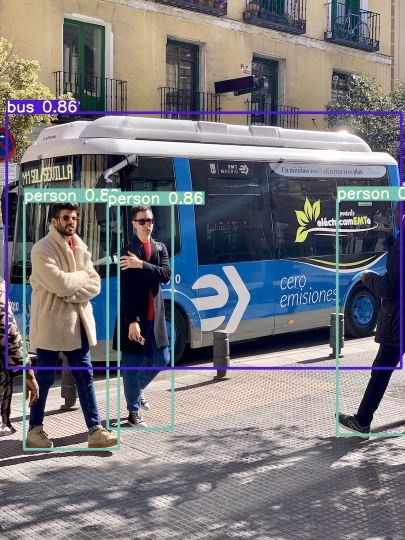

In [14]:
imshow_scale = 0.5
cv2_imshow(cv2.resize(im, None, fx=imshow_scale, fy=imshow_scale))

## Export to torchscript model

In [15]:
# TorchScript export
print(f'Starting TorchScript export with torch {torch.__version__}...')
export_script_name = './checkpoints/yolov5/yolov5s.torchscript.pt'  # filename

Starting TorchScript export with torch 1.7.0...


In [16]:
model_script = torch.jit.script(model)
# model_script.save(export_script_name)
# model_script = torch.jit.load(export_script_name)

In [17]:
model_script.eval()
model_script = model_script.to(device)

## Inference on `torchscript` Backend

In [18]:
out_script = model_script([img_test])

/mnt/yolov5-rt-stack/models/yolo.py:131: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting
  warnings.warn("YOLO always returns a (Losses, Detections) tuple in scripting")


## Varify the Inference Output in `libtorch` backend

In [19]:
for k, v in model_out[0].items():
    torch.testing.assert_allclose(out_script[1][0][k], v, rtol=1e-07, atol=1e-09)

print("Exported model has been tested with libtorch, and the result looks good!")

Exported model has been tested with libtorch, and the result looks good!


### Comparing Inference Time between `pytorch` and `libtorch`

**Time comsumed on `pytorch` backend**

In [20]:
%%time
with torch.no_grad():
    out = model([img_test])

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.1 ms


In [21]:
# Dummy run once for torchscript
with torch.no_grad():
    out_script = model_script([img_test])

**Time comsumed on `libtorch` backend**

In [22]:
%%time
with torch.no_grad():
    out_script = model_script([img_test])

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 8.91 ms
